In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap,ee,rasterio,glob
from rasterio.plot import show,show_hist
import matplotlib.colors as colors
from rasterio import features
from shapely.geometry import shape, box
from matplotlib import colors
import matplotlib.patches as mpatches

# Desafío: Escasez Hídrica, región de Petorca

https://www.dosafios.cl/

In [3]:
crs=4674
region=gpd.read_file('../Datos/Censo2017/R05/REGION_C17.shp').to_crs(crs)
prov=gpd.read_file('../Datos/Censo2017/R05/PROVINCIA_C17.shp').to_crs(crs)
com=gpd.read_file('../Datos/Censo2017/R05/COMUNA_C17.shp').to_crs(crs)
manz=gpd.read_file('../Datos/Censo2017/R05/MANZANA_IND_C17.shp').to_crs(crs)
aldea=gpd.read_file('../Datos/Censo2017/R05/MANZANA_ALDEA_C17.shp').to_crs(crs)

In [4]:
zonas=gpd.read_file('dataton_zonas.gpkg').to_crs(crs)
petorca=zonas[zonas['zona']=='petorca']
com=com.clip(petorca)
manz=manz.clip(petorca)
aldea=aldea.clip(petorca)
comuna=com[com['COMUNA']=='5404']

In [5]:
rios=gpd.read_file('../Datos/Hidrografia/hidrografia_check/hidrografia_check.shp').to_crs(crs).clip(petorca)
rios['tipo']=rios.tipo.str.replace('RÃ­o','Rio')
#rios=rios[rios['tipo']=='Rio']

agua=gpd.read_file('../Datos/Hidrografia/masas_agua/masas_agua.shp').to_crs(crs).clip(petorca)
rios.to_crs(4326).to_file('rios.json', driver="GeoJSON")
agua.to_crs(4326).to_file('agua.json', driver="GeoJSON")
manz.to_crs(4326).to_file('manz.json', driver="GeoJSON")
aldea.to_crs(4326).to_file('aldea.json', driver="GeoJSON")


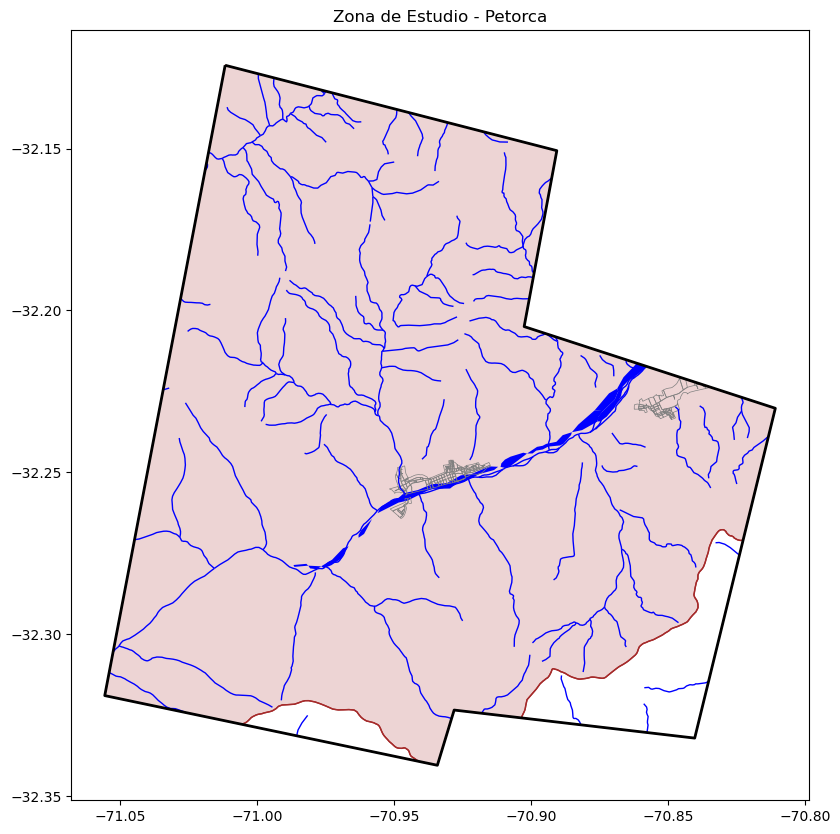

In [6]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
comuna.plot(ax=ax,color='brown',alpha=0.2,label='Petorca',legend=True)

com.boundary.plot(ax=ax,color='brown',lw=1)
manz.boundary.plot(ax=ax,lw=0.5,color='gray')
rios.plot(lw=1,color='b',ax=ax)
agua.plot(lw=1,color='b',ax=ax)
petorca.boundary.plot(ax=ax,lw=2,color='k')
ax.set_title('Zona de Estudio - Petorca');


## Fasat Charlie

In [1]:
import rioxarray as riox
import xarray as xr

In [2]:
fasat=riox.open_rasterio('../Datos/FasatCharlie/FasatCharlie_petorca.nc')
fasat

/Users/paguirre/anaconda3/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/paguirre/anaconda3/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/Users/paguirre/anaconda3/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/paguirre/anaconda3/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(r

<xarray.Dataset>
Dimensions:      (time: 3, x: 4058, y: 4278)
Coordinates:
  * time         (time) object 2013-09-03 15:05:18.094184 ... 2017-12-27 15:1...
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 4.056e+03 4.056e+03 4.058e+03
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 4.276e+03 4.276e+03 4.278e+03
    spatial_ref  int64 0
Data variables:
    nir          (time, y, x) float64 ...
    red          (time, y, x) float64 ...
    green        (time, y, x) float64 ...
    blue         (time, y, x) float64 ...
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

/Users/paguirre/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


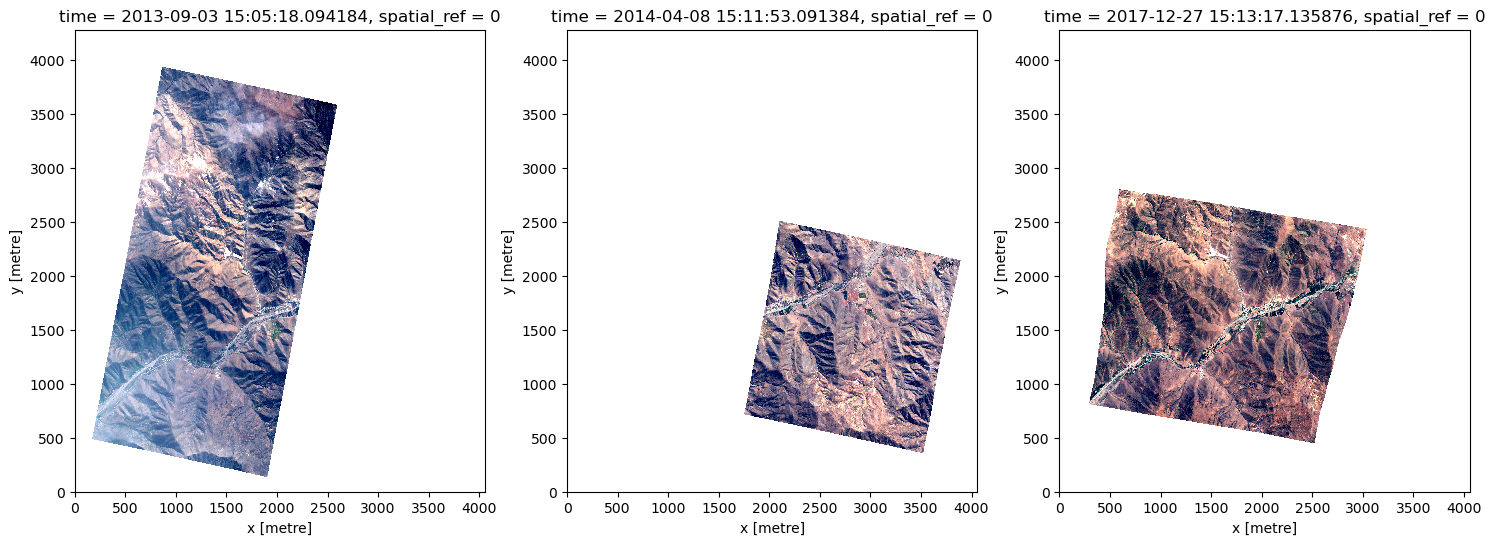

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig,axes=plt.subplots(1,3,figsize=(18,6))

for t in range(3):
    ax=axes[t]

    np.cbrt(0.6*fasat[['red', 'green', 'blue']].isel(time = t)).to_array().plot.imshow(robust = True, ax=ax)

In [9]:
fasat.rio.resolution(),fasat.crs

((1.0, 1.0), 'epsg:32719')

## Sentinel 2

In [15]:
ee.Authenticate()
ee.Initialize(project='ee-aguirrepaula')

Enter verification code:  4/1AeaYSHBuK26xLy_nIuyIKZC8VqrWgcvQn4qyufxcxYkBxUlBvfVYjt6a0GI



Successfully saved authorization token.


### Cloudless functions

In [43]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [44]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))


In [45]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

In [46]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)


### Selección de imágenes

In [37]:
x=petorca.to_crs(4326).geometry[0].geoms[0].exterior.coords.xy[0]
y=petorca.to_crs(4326).geometry[0].geoms[0].exterior.coords.xy[1]
xy=[]
for xi,yi in zip(x,y):
    xy.append([xi,yi])
aoi = ee.Geometry.Polygon(xy)

In [ ]:
START_DATE = '2018-12-15'
END_DATE = '2024-03-28'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [57]:
dates=['2018-12-15','2024-03-28']
collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(aoi).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))    #.filterDate(dates[0],dates[1])
images=collection.aggregate_array('system:id').getInfo()
len(images)

270

### Mapa

In [58]:
im=ee.Image(images[-1]).clip(aoi)
im

In [69]:
im_last=ee.Image(images[-1]).clip(aoi)

Map = geemap.Map(center=[-32.19,-70.87], zoom=12)


vis_params = {"min": 0, "max": 4000, "bands": ["B4", "B3", "B2"]}

Map.addLayer(im_last, vis_params,name='Image')
Map.addLayer(aoi,name='aoi',shown=False)
Map.add_geojson('rios.json', layer_name="Hidrología")
Map.add_geojson('manz.json', layer_name="Manzanas")
Map.add_geojson('agua.json', layer_name="Masas de agua")
Map.add_geojson('aldea.json', layer_name="Aldeas")


Map


Map(center=[-32.19, -70.87], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

## Land Cover

- ESRI 2020 Global Land Use Land Cover from Sentinel-2: https://gee-community-catalog.org/projects/esrilc2020/

In [ ]:
Map = geemap.Map()

region = aoi
start_date = "2021-01-01"
end_date = "2022-01-01"

dw_class = geemap.dynamic_world(region, start_date, end_date, return_type="class")
dw = geemap.dynamic_world(region, start_date, end_date, return_type="hillshade")

dw_vis = {
    "min": 0,
    "max": 8,
    "palette": ["#419BDF","#397D49","#88B053","#7A87C6","#E49635","#DFC35A","#C4281B","#A59B8F","#B39FE1",],}

Map.addLayer(dw_class, dw_vis, "DW Land Cover", False)
Map.addLayer(dw, {}, "DW Land Cover Hillshade")

Map.add_legend(title="Dynamic World Land Cover", builtin_legend="Dynamic_World")
Map.setCenter(-70.87,-32.19, 12)
Map

## Imágenes Aereas

In [5]:
apath='../Datos/Aerial/reprojected_3m'

In [7]:
import glob
ims=glob.glob('%s/*nc'%apath)
ims

['../Datos/Aerial/reprojected_3m/19951009_50961_GEO_proj.nc',
 '../Datos/Aerial/reprojected_3m/19800805_20670_GEO_proj.nc',
 '../Datos/Aerial/reprojected_3m/19951009_50960_GEO_proj.nc',
 '../Datos/Aerial/reprojected_3m/19800805_20973_GEO_proj.nc',
 '../Datos/Aerial/reprojected_3m/19821121_32020_GEO_proj.nc',
 '../Datos/Aerial/reprojected_3m/19951008_50708_modified_proj.nc',
 '../Datos/Aerial/reprojected_3m/19970123_3801_GEO_proj.nc',
 '../Datos/Aerial/reprojected_3m/19951008_50693_GEO_proj.nc',
 '../Datos/Aerial/reprojected_3m/19951008_50709_GEO_proj.nc',
 '../Datos/Aerial/reprojected_3m/19800805_20671_GEO_proj.nc']

In [10]:
dates=[x.split('/')[-1].split('_')[0] for x in ims]
dates=['19800805','19821121','19951008','19951009','19970123','19800805']



['19951009',
 '19800805',
 '19951009',
 '19800805',
 '19821121',
 '19951008',
 '19970123',
 '19951008',
 '19951008',
 '19800805']